In [1]:
!pip install --upgrade gensim

from gensim.downloader import load
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Load pre-trained word2vec model (may take some time to download)
word_model = load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [3]:
def law_cleaning(law):
    # Remove punctuations
    law = law.translate(str.maketrans('', '', string.punctuation + '\r\n\t'))

    # Remove special characters
    law = law.replace('ã', '')
    law = law.replace('Ã', '')

    # Remain only the alphabetic, numeric characters and whitespaces
    law = ''.join([i for i in law if i.isalnum() or i.isspace()])
    return law


def tokenize(text):
    tokens = nltk.word_tokenize(text.lower())
    return tokens


def remove_stopwords(tokens):
    stop_words = set(stopwords.words("english"))
    filtered = [token for token in tokens if token.lower() not in stop_words]
    return filtered


def stemmer(tokens):
    # Create the Porter stemmer object
    pstemmer = PorterStemmer()
    stemmed_words = [pstemmer.stem(token) for token in tokens]
    # Join the list of stemmed words into a single string separated by spaces
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

In [4]:
# Load your CSV files containing Law Text and User Queries
df_law = pd.read_csv("dataset.csv")
df_query = pd.read_csv("SampleQueries.csv")

In [5]:
# Preprocess law data for efficiency
vectorized = TfidfVectorizer(stop_words=stopwords.words("english"))
doc_vectors_tfidf = vectorized.fit_transform(df_law["Law"])

law_vectors_word2vec = []
for law in df_law["Law"]:
    law_tokens = tokenize(law_cleaning(law))
    law_tokens = remove_stopwords(law_tokens)
    law_vector = np.mean([word_model[word] for word in law_tokens if word in word_model], axis=0)
    law_vectors_word2vec.append(law_vector)


# Loop through each user query in the dataframe
for index, row in df_query.iterrows():
  user_query = row["Queries"]

  # Preprocess user input
  cleaned_text = law_cleaning(user_query)
  tokens = tokenize(cleaned_text)
  tokens = remove_stopwords(tokens)
  processed_text = stemmer(tokens)

  # Calculate similarity using both TF-IDF and Word2Vec
  input_vector_tfidf = vectorized.transform([processed_text])
  similarities_tfidf = cosine_similarity(input_vector_tfidf, doc_vectors_tfidf)[0]

  input_vector_word2vec = np.mean([word_model[word] for word in tokens if word in word_model], axis=0)
  similarities_word2vec = cosine_similarity([input_vector_word2vec], law_vectors_word2vec)[0]

  # Combine similarities (simple average)
  combined_similarities = (similarities_tfidf + similarities_word2vec) / 2
  highest_similarity = max(combined_similarities)

  # Update 'Highest Similarity Value' column for the current query
  df_query.at[index, 'Highest Similarity Value'] = highest_similarity

In [6]:
# Filter in-scope queries (Ground Truth Label = 1)
in_scope_data = df_query[df_query['Ground Truth label'] == 1]

# Calculate average highest similarity value for in-scope queries
avg_similarity = in_scope_data['Highest Similarity Value'].mean()

print(f"Average Highest Similarity Value (In-Scope Queries): {avg_similarity}")

Average Highest Similarity Value (In-Scope Queries): 0.5960439917894649


In [7]:
# Calculate average highest similarity value for all queries
avg_similarity = df_query['Highest Similarity Value'].mean()

print(f"Average Highest Similarity Value (All Queries): {avg_similarity}")

Average Highest Similarity Value (All Queries): 0.5037154487259332


In [8]:
df_query.sample(10)

,Queries,Ground Truth label,Highest Similarity Value
83,How is the Victims of Crime and Witnesses Assi...,1,0.523875
697,What legal mechanisms exist for holding indivi...,0,0.423555
256,What are the official languages of Sri Lanka?,1,0.612713
66,Explain the obligations and restrictions impos...,1,0.516855
685,What legal mechanisms exist for holding indivi...,0,0.429170
178,"How does the pre-trial conference, as outlined...",1,0.578957
144,How does the law define and penalize the offen...,1,0.680289
304,Is there a provision for public officers aggri...,1,0.713630
306,Upon delegation of any of its powers to a Comm...,1,0.718322
372,Under what conditions and subject to which reg...,1,0.653983


In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [10]:
# dataframe is named 'df_query' with columns:
#  - Queries (text)
#  - Ground Truth Label (0 - Out-of-Scope, 1 - In-Scope)
#  - Highest Similarity Value (float)
# Filter data for labeled queries
labeled_data = df_query[df_query['Ground Truth label'].notna()]

# Separate labels and similarity values
y_true = labeled_data['Ground Truth label']
# the ground truth label for each query (0 for out-of-scope, 1 for in-scope)
y_pred = labeled_data['Highest Similarity Value']
# the highest similarity scores obtained for each query after comparing them with the laws

In [11]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.45

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       323                        83
Out-of-Scope (Actual)                     8                       398
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       406
           1       0.83      0.98      0.90       406

    accuracy                           0.89       812
   macro avg       0.90      0.89      0.89       812
weighted avg       0.90      0.89      0.89       812



In [12]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.46

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       342                        64
Out-of-Scope (Actual)                    13                       393
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       406
           1       0.86      0.97      0.91       406

    accuracy                           0.91       812
   macro avg       0.91      0.91      0.90       812
weighted avg       0.91      0.91      0.90       812



In [13]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.47

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       354                        52
Out-of-Scope (Actual)                    21                       385
              precision    recall  f1-score   support

           0       0.94      0.87      0.91       406
           1       0.88      0.95      0.91       406

    accuracy                           0.91       812
   macro avg       0.91      0.91      0.91       812
weighted avg       0.91      0.91      0.91       812



In [14]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.48

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       367                        39
Out-of-Scope (Actual)                    30                       376
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       406
           1       0.91      0.93      0.92       406

    accuracy                           0.92       812
   macro avg       0.92      0.92      0.92       812
weighted avg       0.92      0.92      0.92       812



In [15]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.49

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       372                        34
Out-of-Scope (Actual)                    39                       367
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       406
           1       0.92      0.90      0.91       406

    accuracy                           0.91       812
   macro avg       0.91      0.91      0.91       812
weighted avg       0.91      0.91      0.91       812



In [16]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.5

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       379                        27
Out-of-Scope (Actual)                    49                       357
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       406
           1       0.93      0.88      0.90       406

    accuracy                           0.91       812
   macro avg       0.91      0.91      0.91       812
weighted avg       0.91      0.91      0.91       812



In [17]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.51

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       380                        26
Out-of-Scope (Actual)                    56                       350
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       406
           1       0.93      0.86      0.90       406

    accuracy                           0.90       812
   macro avg       0.90      0.90      0.90       812
weighted avg       0.90      0.90      0.90       812



In [18]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.52

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       386                        20
Out-of-Scope (Actual)                    69                       337
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       406
           1       0.94      0.83      0.88       406

    accuracy                           0.89       812
   macro avg       0.90      0.89      0.89       812
weighted avg       0.90      0.89      0.89       812



In [19]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.53

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       391                        15
Out-of-Scope (Actual)                    88                       318
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       406
           1       0.95      0.78      0.86       406

    accuracy                           0.87       812
   macro avg       0.89      0.87      0.87       812
weighted avg       0.89      0.87      0.87       812



In [20]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.54

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       395                        11
Out-of-Scope (Actual)                   110                       296
              precision    recall  f1-score   support

           0       0.78      0.97      0.87       406
           1       0.96      0.73      0.83       406

    accuracy                           0.85       812
   macro avg       0.87      0.85      0.85       812
weighted avg       0.87      0.85      0.85       812



In [21]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.55

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       397                         9
Out-of-Scope (Actual)                   124                       282
              precision    recall  f1-score   support

           0       0.76      0.98      0.86       406
           1       0.97      0.69      0.81       406

    accuracy                           0.84       812
   macro avg       0.87      0.84      0.83       812
weighted avg       0.87      0.84      0.83       812



In [22]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.5960439917894649

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       401                         5
Out-of-Scope (Actual)                   213                       193
              precision    recall  f1-score   support

           0       0.65      0.99      0.79       406
           1       0.97      0.48      0.64       406

    accuracy                           0.73       812
   macro avg       0.81      0.73      0.71       812
weighted avg       0.81      0.73      0.71       812



In [23]:
# Choose a threshold based on your risk tolerance and application needs.
threshold = 0.7

# Classify queries based on the threshold
labeled_data['Predicted Label'] = labeled_data['Highest Similarity Value'].apply(lambda x: 1 if x >= threshold else 0)

# Evaluate performance metrics
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, labeled_data['Predicted Label']),
                                 index=['In-Scope (Actual)', 'Out-of-Scope (Actual)'],
                                 columns=['In-Scope (Predicted)', 'Out-of-Scope (Predicted)'])
print(confusion_matrix_df)

print(classification_report(y_true, labeled_data['Predicted Label']))

                       In-Scope (Predicted)  Out-of-Scope (Predicted)
In-Scope (Actual)                       405                         1
Out-of-Scope (Actual)                   361                        45
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       406
           1       0.98      0.11      0.20       406

    accuracy                           0.55       812
   macro avg       0.75      0.55      0.45       812
weighted avg       0.75      0.55      0.45       812



ROC AUC Score: 0.9672401659831591


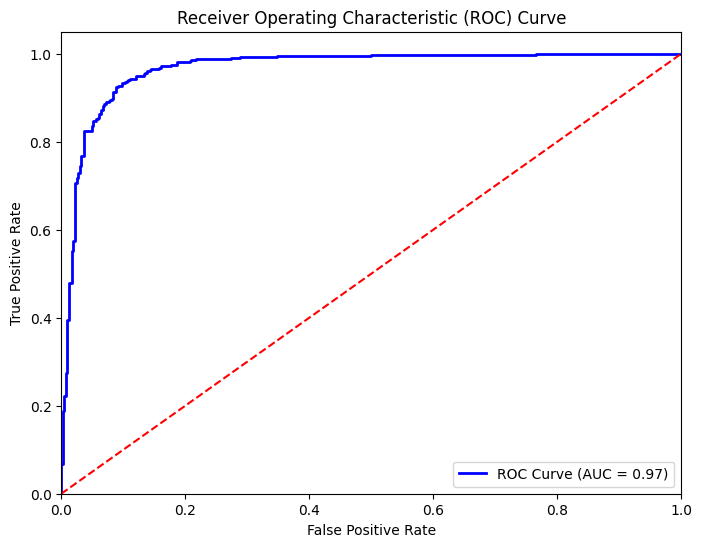

In [24]:
# Calculate ROC AUC score
auc_score = roc_auc_score(y_true, y_pred)
print(f"ROC AUC Score: {auc_score}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()